In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from geo_transform.tps import ThinPlateSpline as tps

import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial
import os

In [2]:
import session_config

In [3]:
session_config.setup_gpus(True, 0.9)

1 Physical GPUs, 1 Logical GPUs


In [7]:
_datapath = "sample_dataset"
filelist = os.listdir(_datapath)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, (200, 200), interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images)

In [8]:
control_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])

control_points[np.newaxis,::].shape

(1, 9, 2)

In [9]:
def make_synthesized_pair(image, motion_vectors, output_size):
    image = image.numpy()
    image = preprocess_input(image)
    control_points = tf.constant([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]], dtype=tf.float32)
    x_s, y_s = tps(control_points[tf.newaxis,::], -motion_vectors[tf.newaxis,::], output_size)
    synth_image = cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC)
    return image, synth_image, motion_vectors

In [10]:
def use_py_function(image, tps_random_rate, output_size):
    motion_vectors = (tf.random.uniform([9, 2]) - 0.5) * 2 * tps_random_rate
    return tf.py_function(make_synthesized_pair, [image, motion_vectors, output_size], [tf.float32, tf.float32, tf.float32])

In [11]:
tps_random_rate = 0.2
output_size = (200, 200)
py_func = partial(use_py_function, tps_random_rate=tps_random_rate,
                      output_size=output_size)

ds = tf.data.Dataset.from_tensor_slices(images)
ds = ds.map(py_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(10)

In [12]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


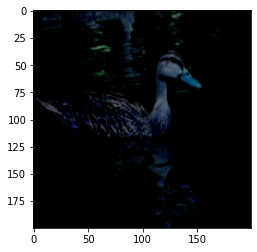

In [13]:
plt.imshow(A[0]/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


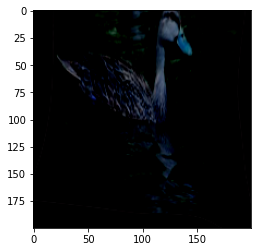

In [14]:
plt.imshow(B[0]/255)

In [15]:
def loss_fn(pred, label):
    control_points = tf.constant([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]], dtype=tf.float32)
    print("control shape", control_points.shape)
    print(pred.shape)
    
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [10,1,1]), pred, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [10,1,1]), label, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    print("distshape", dist.shape)
    loss_mean = tf.reduce_mean(dist)
    return loss_mean


In [16]:
@tf.function
def train_step(image_A, image_B, label, model, optimizer):
    with tf.GradientTape() as tape:
        pred, score = model(image_A, image_B)
        loss = loss_fn(pred, label)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return pred, loss, score

In [17]:
from models.cnn_geo import CNN_geo
from models.modules import Feature_Extractor, Correlation_network, Spatial_transformer_regressor

In [18]:
model = CNN_geo("vgg16", tentative_penalty=True)
optimizer = tf.keras.optimizers.Adam(
        learning_rate=1E-5)

In [19]:
train_loss = tf.metrics.Mean(name='train_loss')
train_score_std = tf.metrics.Mean(name='train_score_std')
x = []
y_loss = []
y_score_std = []
for epoch in range(200):
    for step, (image_a, image_b, label) in enumerate(ds):
        pred, t_loss, score = train_step(
                image_a, image_b, label, model, optimizer)
        score_std = tf.math.reduce_std(score)
        train_loss(t_loss)
        train_score_std(score_std)
    template = 'Epoch {}, Loss: {}, score std {}'
    print(template.format(epoch + 1, train_loss.result(), train_score_std.result()))
    x.append(epoch)
    y_loss.append(train_loss.result().numpy())
    y_score_std.append(train_score_std.result().numpy())
    
    train_loss.reset_states()
    train_score_std.reset_states()

(10, 50, 50, 50, 50)
control shape (9, 2)
(10, 9, 2)
distshape (10, 20, 20)
(10, 50, 50, 50, 50)
control shape (9, 2)
(10, 9, 2)
distshape (10, 20, 20)


ResourceExhaustedError:  OOM when allocating tensor with shape[10,50,50,50,50,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node cnn_geo/correlation_network/Mul (defined at /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_step_6851]

Function call stack:
train_step
